In [1]:
%%time

import scipy.integrate as integrate
from scipy.integrate import solve_ivp
import numpy as np

# This controls which part of the assignment we will be solving for
mode = 'solar'

# Sets all of the constants needed
if mode == 'solar':
    G = 6.6e-11 # N m^2/kg^2

    ### The following section contains the initial postions, velocities and masses for the four bodies.
    
    sun_r0 = np.array([0.0, 0.0, 0.0]) # m
    sun_v0 = np.array([0.0, 0.0, 0.0]) # m/s
    sun_M = 2e30 # kg
    
    earth_r0 = np.array([149.6e9, 0.0, 0.0]) # m
    earth_v0 = np.array([0.0, 29.8e3, 0.0]) # m/s
    earth_M = 5.97e24 # kg
    
    venus_r0 = np.array([108e9, 0.0, 0.0])
    venus_v0 = np.array([0.0, 35e3, 0.0])
    venus_M = 5e24
    
    mars_r0 = np.array([230e9, 0.0, 0.0])
    mars_v0 = np.array([0.0, 24e3, 0.0])
    mars_M = 6.4e23

    # A regularisation term for the force calculation.
    a = 1e-20

    # The end point of simulation, this is 10 years
    t_max = 31557600.0*10 # s

    # How far out to plot our visualisation later
    vis_radius = 300e9 # m

elif mode == 'galaxy':
    G = 4.49e-18 # kpc^3/M_solar/kyear^2

    # Some constants for generating the locations of the bodies
    R_gen = 50 # kpc
    z_scale_factor = 0.25
    N_bodies = 200
    M_bodies = 1e8 # M_solar
    rc = 1 # kpc

    # The end point of the simulation, this is 1 billion years
    t_max = 1000000 # kyr

    # How far out the visualisation should go
    vis_radius = 50 # kpc

else:
  print("Invalid mode")

CPU times: user 1.87 s, sys: 346 ms, total: 2.22 s
Wall time: 687 ms


In [2]:
"""
sun_r0 = np.array([0.0, 0.0, 0.0]) # m
    sun_v0 = np.array([0.0, 0.0, 0.0]) # m/s
    sun_M = 2e30 # kg
    
    earth_r0 = np.array([149.6e9, 0.0, 0.0]) # m
    earth_v0 = np.array([0.0, 29.8e3, 0.0]) # m/s
    earth_M = 5.97e24 # kg
    
    venus_r0 = np.array([108e9, 0.0, 0.0])
    venus_v0 = np.array([0.0, 35e3, 0.0])
    venus_M = 5e24
    
    mars_r0 = np.array([230e9, 0.0, 0.0])
    mars_v0 = np.array([0.0, 24e3, 0.0])
    mars_M = 6.4e23
Functions to provide the plot kwargs in the two cases."""
from __future__ import annotations
def solar_plot_params(body_names: list[str], size_factor: float = 1) -> dict[str, list]:
    """
    Get the color and size key-word argument arrays for the solar system.

    The body names provides the order of the bodies in the plot to ensure proper matching

    Parameters
    ----------
    body_names : list[str]
        Order of bodies as simulated
    size_factor : float, optional
        Multiplicative factor to adjust size (area) of all bodies in plot, by default 1

    Returns
    -------
    dict[str, list]
        Unpack output from this function with ** into ax.scatter.
    """
    # Note sizes are area, not radius
    solar_sizes = {
        "sun": 50,
        "earth": 28,
        "venus": 24,
        "mars": 20,
    }
    solar_colours = {
        "sun": "yellow",
        "earth": "blue",
        "venus": "orange",
        "mars": "red",
    }
    res = {"s":[],"c":[]}
    for body in body_names:
        body = body.lower()
        res["s"].append(solar_sizes[body] * size_factor)
        res["c"].append(solar_colours[body])
    return res

def galaxy_plot_params(n_bodies: int, cmap: str = "hsv", map_range: tuple[float] = (0,1), size: int = 7):
    """
    Get the colour, size and cmap key-word argument values for the galaxy simulation.

    Map range allows the accessing of a subset of a colormap through a range narrower than (0,1).
    See https://matplotlib.org/stable/users/explain/colors/colormaps.html for more colormaps.

    Parameters
    ----------
    n_bodies : int
        Number of bodies in galaxy.
    cmap : str, optional
        Color map to use, by default "hsv"
    map_range : tuple[float], optional
        Subset of colormap to randomly sample, by default (0,1)
    size : int, optional
        Area of bodies, by default 7

    Returns
    -------
    _type_
        _description_
    """
    res = {
        "s": size,
        "c": np.random.uniform(*map_range, size=n_bodies), 
        "cmap": cmap,
    }
    return res

In [3]:
time_points = 200 # Number of points being calculated
t_grid = np.linspace(0, t_max, time_points) # grid of t values used for calculations between initial time and tmax
t_span = (0, t_max)

# get rs and vs from the flattened y array
def get_rs_vs(y_flat):
  rs, vs = y_flat.reshape(y0.shape)
  return rs, vs

# Return the squared length of a vector
def lengthSquared(vec):
  return np.sum(vec**2, axis = -1)

# Set initial conditions
y0 = np.array([
  [sun_r0, venus_r0, earth_r0, mars_r0],
  [sun_v0, venus_v0, earth_v0, mars_v0],
])
m = np.array([sun_M, venus_M, earth_M, mars_M])

# Calculate the derivative
def dy_dt(t, y_flat):
  rs, vs = get_rs_vs(y_flat)
  drs_dt = vs
  a_vector = np.zeros_like(vs)

  for i in range(0, len(m)):
    r_ij = rs - rs[i]

    r_ij_squared = lengthSquared(r_ij) + a**2
    r_ij_magnitude = r_ij_squared ** (3/2)

    force_mag = G * m / r_ij_magnitude
    force_vec = force_mag[:, None] * r_ij

    a_vector[i] = np.sum(force_vec, axis = 0)

  dvs_dt = a_vector
  return np.array([drs_dt, dvs_dt]).flatten()

solution = solve_ivp(dy_dt, t_span, y0.flatten(), t_eval=t_grid, method='BDF', rtol=1e-8)

In [4]:
# Return the total energy of the system
def getTotalEnergy(y_flat):
    # Obtain positions and velocities of bodies
    rs, vs = get_rs_vs(y_flat)

    # Initialize kinetic energy
    E_kinetic_total = 0

    # Initialize potential energy
    E_potential_total = 0

    # Loop over each body i
    for i in range(0, len(m)):
        # Calculate kinetic energy of body
        E_kinetic_total += (1/2) * m[i] * lengthSquared(vs[i])

        # Loop over each body j
        for j in range(0, len(m)):
            if j < i:
                E_potential_total += -G * m[i] * m[j] / np.sqrt(lengthSquared(rs[j] - rs[i]))

    # Calculate total energy
    E_total = E_kinetic_total + E_potential_total
    return E_total

# Initialize array of energy
E_vector = np.zeros(time_points)
# Calculate total energy for each timestep
for i in range(0, time_points):
    E_vector[i] = getTotalEnergy(solution.y[:, i])
    # print(f"t = {i}, E = {Energy[i]}")

    # print(E_vector[i])

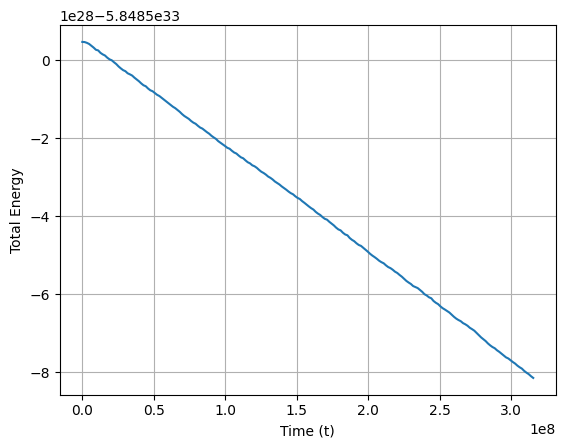

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(t_grid, E_vector)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Total Energy")
ax.grid(True)
plt.show()

In [6]:
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib as mpl

def get_body_coordinates(t):
    """
    Returns the coordinates of each body in a tuple. If we are simulating a solar system then 
    only the x and y coordinates are returned.

    Parameters
    ----------
    t : int
        The time step for which the body coordinates should be returned, where 0 is the first time step.
    """
    #########################
    # Fill in the dots below with the output of your simulation
    # Take your 'solution_y_t', index it with the 't' argument of this function, 
    # and use it to get the x, y, and z coordinates of the simulation bodies.
    #########################
    
    body_x_coordinates = solution.y[:, t].reshape(y0.shape)[0][:,0]
    body_y_coordinates = solution.y[:, t].reshape(y0.shape)[0][:,1]
    if mode == 'solar':
        return body_x_coordinates, body_y_coordinates, None
    elif mode == 'galaxy':
        body_z_coordinates = solution.y[:, t].reshape(y0.shape)[0][:,2]
        return body_x_coordinates, body_y_coordinates, body_z_coordinates

plt.rcParams["animation.html"] = "jshtml" # Makes animations work better in a notebook
plt.rcParams['figure.dpi'] = 100 # Sets the size of the animation in dots per inch
plt.ioff()

plt.close() # Ensure we get a fresh canvas
fig = plt.figure() # Create a new figure to animate in

# First we initiate the plot using the first time slice
body_init_x_coordinates, body_init_y_coordinates, body_init_z_coordinates = get_body_coordinates(0)
# Actually plotting the data, note that we collect the output from scatter
if mode == 'solar':
    ax = plt.axes() # standard 2D axes for the solar system
    # solar_plot_params contains colour and size arguments
    plot_kwargs = solar_plot_params(["sun","venus","earth","mars"], size_factor=2)
    # 2D scatter plot of the x and y coordinates of the solar system bodies
    bodies = ax.scatter(body_init_x_coordinates, body_init_y_coordinates, **plot_kwargs)
elif mode == 'galaxy':
    ax = plt.axes(projection='3d') # 3D axes for the galaxy simulation
    # Size and colour again
    plot_kwargs = galaxy_plot_params(N_bodies,cmap="spring",map_range=(0.6,0.7), size=12)
    # Similar to the solar system case, but this 3D scatter plot has three inputs: x, y, and z
    bodies = ax.scatter(body_init_x_coordinates, body_init_y_coordinates, body_init_z_coordinates, **plot_kwargs)

# Finish initialisation by setting the bounds and labels
ax.set_xlim(-300e9,300e9)
ax.set_xlabel("x")
ax.set_ylim(-300e9,300e9)
ax.set_ylabel("y")
if mode == 'galaxy':
    ax.set_zlim(-300e9,300e9)
    ax.set_zlabel("z")
ax.set_aspect('equal') # Ensure we get a square plot

def animate(t):
    """
    Animation function, at any given timestep returns the updated 'artists' bodies so that the animator
    can update the plot.
    """
    body_x_coordinates, body_y_coordinates, body_z_coordinates = get_body_coordinates(t+1)
    # Now we update the coordinates. They are called offsets underneath for a scatter plot
    if mode == 'solar':
        # Set offsets requires an (N, 2) array
        bodies.set_offsets(np.array([body_x_coordinates, body_y_coordinates]).T)
    elif mode == 'galaxy':
        # No setter method exists for 3d so we set the points manually        
        bodies._offsets3d = (body_x_coordinates, body_y_coordinates, body_z_coordinates)

    # We also spin the plot inside
    if mode == 'galaxy':
        # We only set the z limits and camera rotation for a 3D plot
        ax.azim = ax.azim + 0.2
    
    return bodies, # Must return a tuple or list of the 'artists', the comma ensures this is a tuple

# By passing blit=True, we are telling FuncAnimation that our animate function will return the artists with
# the changed data. As a result it automatically only updates the relevant parts of the plot.
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=(len(solution.y.T) - 1), interval = 100, blit=True)
plt.close()
anim